In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA

from scipy import sparse as sp

import sys
sys.path.insert(1, '../')

from tools import get_optimal_temperature

%matplotlib inline

## Generate a directed network

## Inferring ranks and group preferences

$$ H^{++} = H(s, \theta) + \frac{1}{2} \lambda_s ||s||_2^2 + \frac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

In [2]:
def assign_groups(N, k, rand_seed=None):
    np.random.seed(rand_seed)
    groups = np.random.randint(0, k, N)
    G = np.zeros((N, k))
    for i, g_i in enumerate(groups):
        G[i, g_i] = 1
    
    return groups, G

def generate_ranks(N, G, s_params, theta_params, rand_seed=None):
    
    np.random.seed(rand_seed)
    s = np.random.normal(s_params[0], s_params[1]**2, N)

    np.random.seed(rand_seed)
    theta = np.random.normal(theta_params[0], theta_params[1]**2, G.shape[1])

    ranks = s + np.matmul(G, theta)
    
    return s, theta, ranks

def generate_network(N, beta, ranks, avg_degree, rand_seed=None):


#     P = np.zeros((N, N))
#     for i in range(N):
#         for j in range(N):
#             energy = -2 * beta * (ranks[i] - ranks[j])
#             P[i,j] = 1 / (1 + np.exp(energy))

#     np.random.seed(rand_seed)
#     num_games = np.random.poisson(max_games//2, (N, N))
#     num_games = num_games + num_games.T # Quick fix to make this matrix symmetric
#     np.fill_diagonal(num_games, 0) # i cannot play against itself

#     A = np.zeros((N, N))
#     for i in range(0, N):
#         for j in range(i, N):
#             games_won = np.random.binomial(num_games[i,j], P[i,j])
#             A[i,j] = games_won
#             A[j,i] = num_games[i,j] - games_won

    scaled_exp_energy = np.zeros((N, N))
    Z = 0
    for i in range(N):
        for j in range(N):
            energy_ij = 0.5 * np.power(ranks[i]-ranks[j]-1, 2)
            scaled_exp_energy[i, j] = np.exp(-beta * energy_ij)
            Z += scaled_exp_energy[i, j]
    c = float(avg_degree * N) / Z
    
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue

            lambda_ij = c * scaled_exp_energy[i, j]
            A[i, j] = np.random.poisson(lambda_ij)
            
    return A

In [3]:
def solve_springrank_sparse(A, G, lamb_s, lamb_theta, solver='spsolve'):
    
    # Get array shapes
    k = G.shape[1]
    N, M = A.shape
    assert(N == M)
    
    # Construct Laplacian
    # Look into scipy.sparse.csgraph.laplacian for sparse implementation
    k_in = np.sum(A, 0)
    k_out = np.sum(A, 1)
    D = np.diag(k_out + k_in)
    L = D - (A + A.T)
    
    # Make everything sparse
    L = sp.csr_matrix(L)
    G = sp.csr_matrix(G)
    I_n = sp.eye(N)
    I_k = sp.eye(k)
    
    # Construct the LHS matrix
    block_1 = L + lamb_s*I_n
    block_2 = L @ G
    block_3 = G.T @ L
    block_4 = G.T @ block_2 + lamb_theta*I_k
    top = sp.hstack([block_1, block_2])
    bot = sp.hstack([block_3, block_4])
    K = sp.vstack([top, bot])
    
    # Construct RHS vector
    # # d_top = sp.csr_matrix(k_out - k_in).T
    # # d_bot = G.T @ d_top
    # # d_hat = sp.vstack([d_top, d_bot])
    d_top = k_out - k_in
    d_bot = np.matmul(G.T.toarray(), d_top)
    d_hat = np.append(d_top, d_bot, axis=0)
    
    # Solve using sparse or iterative solvers
    if solver == 'spsolve':
        x = spLA.spsolve(K, d_hat)
    elif solver == 'bicgstab':
        output = spLA.bicgstab(K, d_hat) #.toarray())
        x = output[0]
    elif solver == 'lsqr':
        output = spLA.lsqr(K, d_hat) #.toarray())
        x = output[0]
    else:
        output = spLA.bicgstab(K, d_hat) #.toarray())
        x = output[0]
    
    # Make x dense
    try:
        x = x.toarray()
    except AttributeError:
        pass
    
    print(x.shape)
    
    return x

def solve_springrank_dense(A, G, lamb_s, lamb_theta):
    
    k = G.shape[1]
    N, M = A.shape
    assert(N == M)
    
    # Construct Laplacian
    d_out = np.sum(A, axis=1)
    d_in = np.sum(A, axis=0)
    D_out = np.diag(d_out)
    D_in = np.diag(d_in)
    L = D_out + D_in - (A + A.T)
    
    # Construct LHS matrix
    block_1 = L + lamb_s * np.eye(N)
    block_2 = np.matmul(L, G)
    block_3 = np.matmul(G.T, L)
    block_4 = np.matmul(G.T, block_2) + lamb_theta * np.eye(k)
    top = np.append(block_1, block_2, axis=1)
    bottom = np.append(block_3, block_4, axis=1)
    K = np.append(top, bottom, axis=0)
    
    # Construct RHS vector
    d_top = d_out - d_in
    d_bottom = np.matmul(G.T, d_top)
    d = np.append(d_top, d_bottom, axis=0)
    
    # Solve
    x, res, rank, eig = LA.lstsq(K, d, rcond=None)
    
    return x

## Simulations

In [4]:
N = 500
k = 4
beta = 4
s_params = (0, 1)
theta_params = (0, 1)
avg_degree = 10

groups, G = assign_groups(N, k)
s, theta, ranks = generate_ranks(N, G, s_params, theta_params)
A = generate_network(N, beta, ranks, avg_degree)

- Define an error function to tune for regularization coefficients?

In [5]:
lamb_s = 1e-5
lamb_theta = 1e-5

x_sp = solve_springrank_sparse(A, G, lamb_s, lamb_theta, solver='bicgstab')

# x_dense = solve_springrank_dense(A, G, lamb_s, lamb_theta)
# err = LA.norm(x_sp - x_dense)
# print(err)

(504,)


In [6]:
s_est = x_sp[:N]
theta_est = x_sp[N:]
ranks_est = s_est + np.matmul(G, theta_est)

In [7]:
# beta_hat = []
# for i in range(N):
#     for j in range(i+1, N):
#         beta_ij = 1 / (ranks_est[i] - ranks_est[j]) * np.log((A[i,j] + 1) / (A[j,i] + 1))
#         beta_hat.append(beta_ij)
# beta_hat_avg = np.mean(beta_hat)
        
# beta_est = get_optimal_temperature(ranks_est, A)

# print(beta_hat_avg)
# print(beta_est)

# # plt.figure(figsize=(8,6))
# # plt.scatter(list(range(N*(N-1)//2)), beta_hat, s=10, marker='.')
# # plt.show()

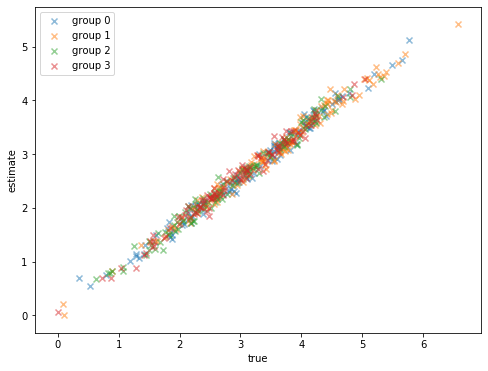

In [8]:
alpha = 0.5
scaling = 1

plt.figure(figsize=(8,6))

for i in range(np.max(groups)+1):
#     print(theta[i], (theta_hat[i]-0.29)*beta_hat)
#     plt.scatter(s[groups==i] - np.min(s),
#                 (s_est[groups==i] - np.min(s_est))*scaling,
#                 marker='x', alpha=alpha,
#                 label="group {}".format(i))
    plt.scatter(ranks[groups==i] - np.min(ranks),
                (ranks_est[groups==i] - np.min(ranks_est))*scaling,
                marker='x', alpha=alpha,
                label="group {}".format(i))

plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

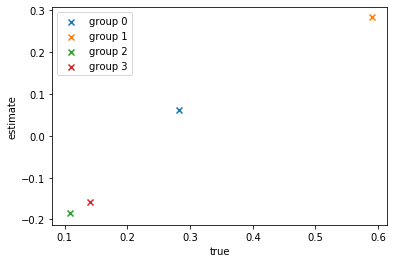

In [9]:
for i in range(np.max(groups)+1):
    plt.scatter(theta[i],
                theta_est[i],
                marker='x',
                label="group {}".format(i))

plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

- How to recover $\beta$
- Things that we need to recover ranks
- Things that we need to recover group penalties
- Regularization - Identify correct regularization coefficients
- ~Use a sparse/iterative solver~
- See results for different $k, N$